# 1.1. Baseline - The Last Value is All You Need

Forecasting microbusiness density for 3,154 counties over 8 months is a challenging task. Inspired by [Chris Deotte](https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/418287)'s simple yet effective approach, I'm starting with a straightforward method: using the last known value for each county. This baseline approach, adjusted with open census data, has proven powerful without needing complex mathematical models or training steps. All we need is the latest recorded microbusiness density for each county.

In [1]:
import os, datetime
from tqdm import tqdm

import numpy as np
import pandas as pd

from utils import SMAPE

pd.options.mode.chained_assignment = None 

In [2]:
data_dir = '../data/'

# train data
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_revealed_test = pd.read_csv(os.path.join(data_dir, 'revealed_test.csv'))
df_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
df_census = pd.read_csv(os.path.join(data_dir, 'census_starter.csv'))

# test data
df_test = pd.read_csv(os.path.join(data_dir, 'all_revealed_test.csv'))

## 1. yield last known value of each county

In [3]:
# type casting
df_train.first_day_of_month = pd.to_datetime(df_train.first_day_of_month)

# sort data by cfips and first_day_of_month
df_train = df_train.sort_values(by=['cfips', 'first_day_of_month'])

df_train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
# select last value only of each county
df_lastvalues = df_train.drop_duplicates(subset='cfips', keep='last')
cfips2lastvalues = {
	cfips: md for cfips, md in zip(
		df_lastvalues['cfips'], df_lastvalues['microbusiness_density'])}

## 2. Forecasting with the Last Known Value with `cfips`

Since I used the last known value (2022-10-01) for each county to make forecasts, every instance is predicted with the same value. Clearly, holding an identical value over 8 months may not be realistic. I could compare this approach with other methods like ARIMA (a traditional statistical model), GRU (a time-series deep learning model), or even boosting models (powerful machine learning techniques).

In [5]:
# set cfips of each
df_submission['cfips'] = df_submission.row_id.apply(lambda x: int(x.split('_')[0]))
df_submission['first_day_of_month'] = pd.to_datetime(df_submission.row_id.apply(lambda x: x.split('_')[1]))

# set submission with the last value by cfips (forecasts)
df_submission.microbusiness_density = df_submission.cfips.map(cfips2lastvalues)

## 3. Evaluation

I calculuated estimated public and private values since they are no longer testable in this moment.

In [6]:
def calculate_public_private_score(df_submission, df_test, df_revealed_test):

	# evaluation with pre-define smape
	private_smape = SMAPE(
		df_test.microbusiness_density.values, 
		df_submission.microbusiness_density.values).item()
	print(f'estimated private SMAPE: {private_smape:.4f}')

	# select 2022 data only for calculating public score
	submission = df_submission[df_submission.first_day_of_month.dt.year == 2022]

	# sort new test data along the order of submission
	sortmap = {val:idx for idx, val in enumerate(df_revealed_test.row_id.values)}
	submission['sortmap'] = submission.row_id.map(sortmap)
	submission = submission.sort_values('sortmap').drop(columns='sortmap')
	
	# evaluation with pre-define smape
	public_smape = SMAPE(
	df_revealed_test.microbusiness_density.values, 
	submission.microbusiness_density.values).item()
	print(f'estimated public SMAPE: {public_smape:.4f}')

	return public_smape, private_smape

In [7]:
submission = df_submission[~df_submission.cfips.isin([2195, 2275, 15005])]
test = df_test[~df_test.microbusiness_density.isna()]
revealed_test = df_revealed_test[~df_revealed_test.cfips.isin([2195, 2275, 15005])]

public_smape, private_smape = calculate_public_private_score(
	submission, test, revealed_test)

estimated private SMAPE: 4.5913
estimated public SMAPE: 1.7710


plain last value forecasts
- estimated private SMAPE: 4.5913
- estimated public SMAPE: 1.7710

The basic last-value forecasting performs well over a short period, such as in 2022, but does not hold up over the long term, covering the entire test period (November 2022 to June 2023). Then, it's time to adjust it!

## 4. Adjusting microbusiness density with 2021 census data.

I'm saying it again, this entire idea is from [Chris Deotte](https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/418287).

Let's just get back to the definition of `microbusiness_density`. The [Dataset Description](https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/data) says;

> `microbusiness_density` - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.

This could be translated below with mathmatical expression:

> `microbusiness_density` = (the number of microbusinesses) / (the number of adults) * 100

Here, <u>the number of microbusinesses</u> is updated in a **monthly** basis but <u>the number of adults</u> is updated yearly and lagged 2 years. This means the target value varies with the those two variables and the change of <u>the number of adults</u> might impact strongly the micro_business density as much as <u>the number of microbusinesses</u>. Luckily we already have the real value of <u>the number of microbusinesses</u>, then we can figure out the impact of the yearly varying variable.

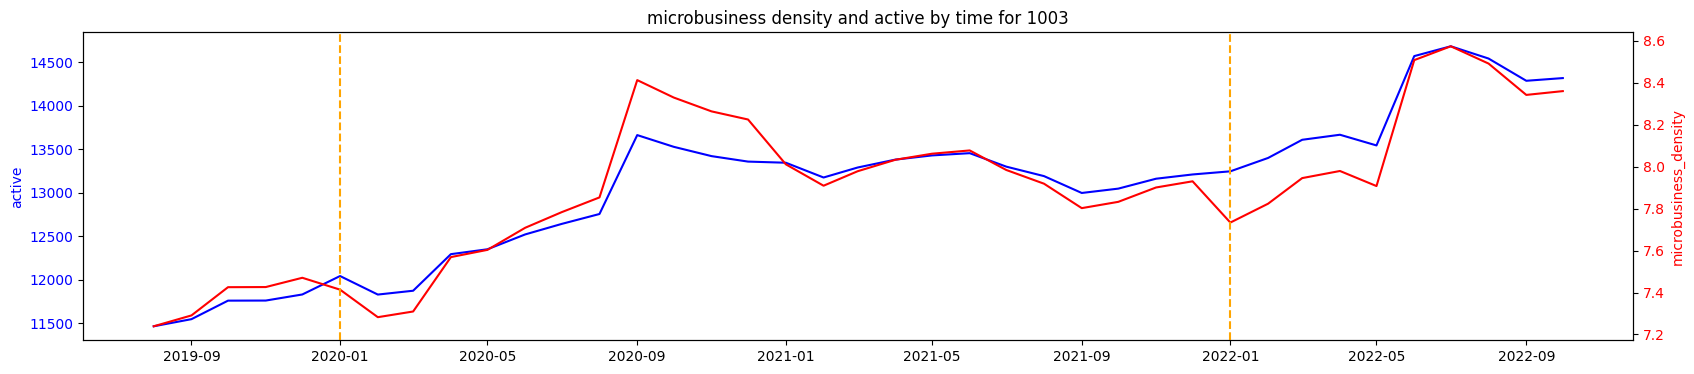

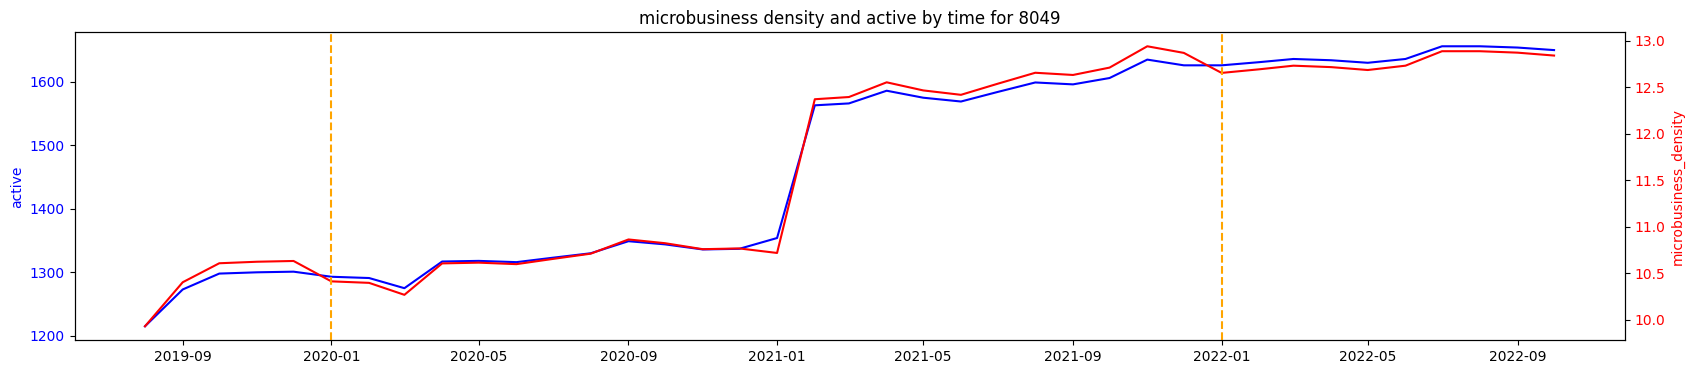

In [8]:
import matplotlib.pyplot as plt

def draw_density_and_active_by_time(df_train, county):
	
	# select data
	data = df_train[df_train['cfips'] == county]

	fig, ax = plt.subplots(1,1, figsize=(20,4))
	ax.plot(data.first_day_of_month, data.active, color='blue')
	ax.set_ylabel('active', color='blue')
	ax.tick_params(axis='y', labelcolor='blue')

	ax2 = ax.twinx()
	ax2.plot(data.first_day_of_month, data.microbusiness_density, color='red')
	ax2.set_ylabel('microbusiness_density', color='red')
	ax2.tick_params(axis='y', labelcolor='red')

	plt.axvline(x=pd.to_datetime('2020-01-01'), ls='--', color='orange')
	plt.axvline(x=pd.to_datetime('2022-01-01'), ls='--', color='orange')
	plt.title(f'microbusiness density and active by time for {county}')
	plt.show()


draw_density_and_active_by_time(df_train, 1003)
draw_density_and_active_by_time(df_train, 8049)

Based on the above plots, obviously cherry-picked, `active` the number of microbusinesses is maintaining or going up a little, `microbusiness_density` fell down rapidly. This might be influenced by the variation of <u>the number of adults</u> for this county.

The above comparison clearly says that we should thorougly consider the change of the number of adults. We actually get to estimate <u>the number of adults</u> over 2017-2020 based on data over 2019-2022. HOWEVER, our target period includes 2023, which needs 2021's <u>the number of adults</u>. Luckily, Chris Deotto has already uploaded the census data on kaggle. All I have to do is to download, transform and apply this dataset to adjust 2023's forecasts.

In [9]:
# load 2020 dataset
COLS = ['GEO_ID','NAME','S0101_C01_026E']
df2020 = pd.read_csv(
	os.path.join(data_dir, 'census', 'ACSST5Y2020.S0101-Data.csv'),usecols=COLS
	).iloc[1:]
df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype('int')
print(df2020.shape)
df2020.head()

(3221, 3)


/var/folders/jz/wsn3kwpx7cq0nsrxkk2g7nrr0000gn/T/ipykernel_77103/3539904192.py:3: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2020 = pd.read_csv(


,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",42496
2,0500000US01003,"Baldwin County, Alabama",171296
3,0500000US01005,"Barbour County, Alabama",19804
4,0500000US01007,"Bibb County, Alabama",17790
5,0500000US01009,"Blount County, Alabama",44383


In [10]:
# load 2021 dataset
df2021 = pd.read_csv(
	os.path.join(data_dir, 'census', 'ACSST5Y2021.S0101-Data.csv'), usecols=COLS
	).iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
print(df2021.shape)
df2021.head()

(3221, 3)


/var/folders/jz/wsn3kwpx7cq0nsrxkk2g7nrr0000gn/T/ipykernel_77103/2120076165.py:2: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv(


,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",44438
2,0500000US01003,"Baldwin County, Alabama",178105
3,0500000US01005,"Barbour County, Alabama",19995
4,0500000US01007,"Bibb County, Alabama",17800
5,0500000US01009,"Blount County, Alabama",45201


In [11]:
# extract cfips from GEO_ID
df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

In [12]:
# map census with its county
df_submission['adult2020'] = df_submission.cfips.map(adult2020)
df_submission['adult2021'] = df_submission.cfips.map(adult2021)
df_submission.head()

,row_id,microbusiness_density,cfips,first_day_of_month,adult2020,adult2021
0,1001_2022-11-01,3.463856,1001,2022-11-01,42496,44438
1,1003_2022-11-01,8.359798,1003,2022-11-01,171296,178105
2,1005_2022-11-01,1.232074,1005,2022-11-01,19804,19995
3,1007_2022-11-01,1.287240,1007,2022-11-01,17790,17800
4,1009_2022-11-01,1.831783,1009,2022-11-01,44383,45201


I restrictively adjusted 2023 `microbusiness_density` forecasts with 2021 adult population.

In [13]:
df_submission['adjusted_microbusiness_density'] = df_submission['microbusiness_density'].copy()

# filter 2023 data only
mask_2023 = df_submission['first_day_of_month'].dt.year == 2023

# adjust 2023 forecasts with 2021 census
df_submission.loc[mask_2023, 'adjusted_microbusiness_density'] = \
	df_submission.loc[mask_2023, 'microbusiness_density'] * df_submission.loc[mask_2023, 'adult2020'] / df_submission.loc[mask_2023, 'adult2021']

To compare Chris Deotte’s implementation with mine, I also created `adjusted_microbusiness_density_all`, which adjusts all densities using the 2021 population, rather than applying a different population for each year.

In [14]:
# adjust all forecasts with 2021 census
df_submission['adjusted_microbusiness_density_all'] = df_submission['microbusiness_density'] * df_submission['adult2020'] / df_submission['adult2021']

In [15]:
# evaluation
## reconstructed test data includes NaN for 3 counties [2195, 2275, 15005] which need to be excluded for evaluation
submission = df_submission[~df_submission.cfips.isin([2195, 2275, 15005])]
test = df_test[~df_test.microbusiness_density.isna()]
revealed_test = df_revealed_test[~df_revealed_test.cfips.isin([2195, 2275, 15005])]

# evaluation with pre-define smape
private_smape = SMAPE(
	test.microbusiness_density.values, 
	submission.microbusiness_density.values).item()
print(f'estimated plain SMAPE: {private_smape:.4f}') # 4.5913

private_smape = SMAPE(
	test.microbusiness_density.values, 
	submission.adjusted_microbusiness_density.values).item()
print(f'estimated adjusted 2023only SMAPE: {private_smape:.4f}') # 3.8440

private_smape = SMAPE(
	test.microbusiness_density.values, 
	submission.adjusted_microbusiness_density_all.values).item()
print(f'estimated adjusted all SMAPE: {private_smape:.4f}') # 4.2845

estimated plain SMAPE: 4.5913
estimated adjusted 2023only SMAPE: 3.8440
estimated adjusted all SMAPE: 4.2845


Evaluation Results
- estimated plain SMAPE: 4.5913
- estimated adjusted 2023only SMAPE: 3.8440
- estimated adjusted all SMAPE: 4.2845

FYI, private LB (88% of the test data)
- 1st place: 3.7877
- 10st place: 3.8827
- 354st place: 4.1288
- Chris Deotte came in 3rd place with SMAPE: 3.8405 (adjusted all). He might be ranked higher than 3rd if he adjusted 2023 forecasts only.

The code below was used to compare each experiment across different years.

In [16]:
# evaluation with pre-define smape
mask_2023 = df_submission['first_day_of_month'].dt.year == 2023

private_smape = SMAPE(
	test.loc[mask_2023, 'microbusiness_density'].values, 
	submission.loc[mask_2023, 'microbusiness_density'].values).item()
print(f'estimated plain SMAPE: {private_smape:.4f}') # 5.6135
 
private_smape = SMAPE(
	test.loc[mask_2023, 'microbusiness_density'].values, 
	submission.loc[mask_2023, 'adjusted_microbusiness_density'].values).item()
print(f'estimated adjusted 2023only SMAPE: {private_smape:.4f}') # 4.6172

private_smape = SMAPE(
	test.loc[mask_2023, 'microbusiness_density'].values, 
	submission.loc[mask_2023, 'adjusted_microbusiness_density_all'].values).item()
print(f'estimated adjusted all SMAPE: {private_smape:.4f}') # 4.6172

estimated plain SMAPE: 5.6135
estimated adjusted 2023only SMAPE: 4.6172
estimated adjusted all SMAPE: 4.6172


In [17]:
# evaluation with pre-define smape
# sort new test data along the order of submission
sortmap = {val:idx for idx, val in enumerate(df_test.row_id.values)}
df_submission['sortmap'] = df_submission.row_id.map(sortmap)
df_submission = df_submission.sort_values('sortmap').drop(columns='sortmap')

mask_2022 = df_submission['first_day_of_month'].dt.year == 2022

private_smape = SMAPE(
	test.loc[mask_2022, 'microbusiness_density'].values, 
	submission.loc[mask_2022, 'microbusiness_density'].values).item()
print(f'estimated plain SMAPE: {private_smape:.4f}') # 1.5246

private_smape = SMAPE(
	test.loc[mask_2022, 'microbusiness_density'].values, 
	submission.loc[mask_2022, 'adjusted_microbusiness_density'].values).item()
print(f'estimated adjusted 2023only SMAPE: {private_smape:.4f}') # 1.5246

private_smape = SMAPE(
	test.loc[mask_2022, 'microbusiness_density'].values, 
	submission.loc[mask_2022, 'adjusted_microbusiness_density_all'].values).item()
print(f'estimated adjusted all SMAPE: {private_smape:.4f}') # 3.2863

estimated plain SMAPE: 1.5246
estimated adjusted 2023only SMAPE: 1.5246
estimated adjusted all SMAPE: 3.2863


# Conclusion

Forecasting with the last known value exceeded expectations. To understand why this simple approach performed well and to further improve forecasting accuracy, I plan to implement and analyze other methods, such as ARIMA (a traditional statistical model), GRU (a time-series deep learning model), and boosting models (powerful machine learning techniques).